In [194]:
from rockit import *
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt


In [195]:
# Points
start = np.array([0, 0, 0])
target1 = np.array([5, 5, -15])
target2 = np.array([30, 0, -60])
max_bur = 0.05 # max build-up rate in rad/m

In [196]:
# OCP
ocp = Ocp()

In [197]:
# def trajectory_stage(opc):
#     stage = ocp.stage(T=FreeTime(5))
#     #ocp.method(MultipleShooting(N=20))

#     x, y, z, t, az, inc = [stage.state() for _ in range(6)]

#     u_az_rate_ds = ocp.control()     # Represents u_1 = d(azimuth)/ds
#     u_inc_rate_ds = ocp.control() # Represents u_2 = d(inclination)/ds
#     inverse_rop = ocp.control()           # Represents u_3 = 1/ROP = 1/speed

#     # The geometric part of the dynamics (speed has been factored out)
#     v1_x_ds = ca.sin(inc) * ca.cos(az)
#     v1_y_ds = ca.sin(inc) * ca.sin(az)
#     v1_z_ds = ca.cos(inc)

#     stage.set_der(x, v1_x_ds)
#     stage.set_der(y, v1_y_ds)
#     stage.set_der(z,v1_z_ds)
#     stage.set_der(t, inverse_rop)
#     stage.set_der(az, u_az_rate_ds)
#     stage.set_der(inc, u_inc_rate_ds)

#     stage.method(MultipleShooting(N=1, M=20, intg='rk'))
#     return x, y, z, t, az, inc, u_az_rate_ds, u_inc_rate_ds, inverse_rop

In [198]:
help(ocp.control)

Help on method control in module rockit.stage:

control(n_rows=1, n_cols=1, order=0, scale=1, domain='real', meta=None) method of rockit.ocp.Ocp instance
    Create a control signal to optimize for

    A control signal is parametrized as a piecewise polynomial.
    By default (order=0), it is piecewise constant.

    Parameters
    ----------
    n_rows : int, optional
        Number of rows
    n_cols : int, optional
        Number of columns
    order : int, optional
        Order of polynomial. order=0 denotes a constant.
    scale : float or :obj:`~casadi.DM`, optional
        Provide a nominal value of the state for numerical scaling
        In essence, this has the same effect as defining u = scale*ocp.control(),
        except that set_initial(u, ...) keeps working
        Default: 1
    domain : str, optional
        Domain of the control signal. Possible values: 'real' (default), 'integer'
    Returns
    -------
    s : :obj:`~casadi.MX`
        A CasADi symbol representing 

In [199]:
# ----- Stage 1 -----
stage1 = ocp.stage(t0 = 0 ,T=FreeTime(5))
#ocp.method(MultipleShooting(N=20))

x1, y1, z1, t1, az1, inc1 = [stage1.state() for _ in range(6)]

u_az1_rate_ds = stage1.control()     # Represents u_1 = d(azimuth)/ds
u_inc1_rate_ds = stage1.control() # Represents u_2 = d(inclination)/ds
inverse_rop1 = stage1.control()           # Represents u_3 = 1/ROP = 1/speed

# The geometric part of the dynamics (speed has been factored out)
v1_x_ds = ca.sin(inc1) * ca.cos(az1)
v1_y_ds = ca.sin(inc1) * ca.sin(az1)
v1_z_ds = ca.cos(inc1)

stage1.set_der(x1, v1_x_ds)
stage1.set_der(y1, v1_y_ds)
stage1.set_der(z1,v1_z_ds)
stage1.set_der(t1, inverse_rop1)
stage1.set_der(az1, u_az1_rate_ds)
stage1.set_der(inc1, u_inc1_rate_ds)

stage1.method(DirectCollocation(N=10, M=20, intg='rka')) 

stage1.subject_to(t1>=0)
stage1.subject_to(stage1.t0 == 0)  # Stage starts at time 0
stage1.subject_to(stage1.at_t0(x1) == start[0])
stage1.subject_to(stage1.at_t0(y1) == start[1])
stage1.subject_to(stage1.at_t0(z1) == start[2])

stage1.subject_to(stage1.at_tf(x1) == target1[0])
stage1.subject_to(stage1.at_tf(y1) == target1[1])
stage1.subject_to(stage1.at_tf(z1) == target1[2])

In [200]:
# # if False:
# # ----- Stage 2 -----
# stage2 = ocp.stage(T=FreeTime(5))
# # stage2.method(MultipleShooting(N=10))

# x2, y2, z2, t2, az2, inc2 = [stage2.state() for _ in range(6)]
# u_az2_rate_ds = ocp.control()     # Represents u_1 = d(azimuth)/ds
# u_inc2_rate_ds = ocp.control() # Represents u_2 = d(inclination)/ds
# inverse_rop2 = ocp.control()           # Represents u_3 = 1/ROP = 1/speed

# # The geometric part of the dynamics (speed has been factored out)
# v2_x_ds = ca.sin(inc1) * ca.cos(az1)
# v2_y_ds = ca.sin(inc1) * ca.sin(az1)
# v2_z_ds = ca.cos(inc1)

# stage2.set_der(x2,v2_x_ds)
# stage2.set_der(y2, v2_y_ds)
# stage2.set_der(z2, v2_z_ds)
# stage2.set_der(t2, u_inc2_rate_ds)
# stage2.set_der(az2, u_az2_rate_ds)
# stage2.set_der(inc2, inverse_rop2)

# stage2.method(DirectCollocation(N=1, M=20, intg='rk'))

# # State link stage 1 to stage 2
# stage2.subject_to(stage2.t0 == stage1.tf)
# stage2.subject_to(stage2.at_t0(x2) == stage1.at_tf(x1))
# stage2.subject_to(stage2.at_t0(y2) == stage1.at_tf(y1))
# stage2.subject_to(stage2.at_t0(z2) == stage1.at_tf(z1))
# stage2.subject_to(stage2.at_t0(t2) == stage1.at_tf(t1))
# stage2.subject_to(stage2.at_t0(az2) == stage1.at_tf(az1))
# stage2.subject_to(stage2.at_t0(inc2) == stage1.at_tf(inc1))

# stage2.subject_to(stage2.at_tf(x2) == target2[0])
# stage2.subject_to(stage2.at_tf(y2) == target2[1])
# stage2.subject_to(stage2.at_tf(z2) == target2[2])

In [ ]:
# Constraints


stage1.subject_to(inc1 >= ca.pi/2)
stage1.subject_to(inc1 <= 3*ca.pi/2)
# stage2.subject_to(inc2 >= ca.pi/2)
# stage2.subject_to(inc2 <= 3*ca.pi/2)

stage1.subject_to(u_inc1_rate_ds >= -max_bur)
stage1.subject_to(u_inc1_rate_ds <=  max_bur)
stage1.subject_to(u_az1_rate_ds >= -max_bur)
stage1.subject_to(u_az1_rate_ds <=  max_bur)
# stage2.subject_to(u_inc2_rate_ds >= -max_bur)
# stage2.subject_to(u_inc2_rate_ds <=  max_bur)


rop_max = 30 # max speed in m/min
rop_min = 5  # min speed (must be > 0)

# If rop_min <= ROP <= rop_max, then 1/rop_max <= 1/ROP <= 1/rop_min
stage1.subject_to(inverse_rop1 >= 1/rop_max)
stage1.subject_to(inverse_rop1 <= 1/rop_min)

# stage2.subject_to(inverse_rop2 >= 1/rop_max)
# stage2.subject_to(inverse_rop2 <= 1/rop_min)


In [202]:
# Objective
# ocp.add_objective(stage2.at_tf(t2))
ocp.add_objective(stage1.at_tf(t1))

In [203]:
# Solve
# ocp.method(MultipleShooting(N=20))
ocp.solver("ipopt", {'ipopt.max_iter': 500}) 
sol = ocp.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    42406
Number of nonzeros in inequality constraint Jacobian.:      100
Number of nonzeros in Lagrangian Hessian.............:     8401

Total number of variables............................:     6037
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6006
Total number of inequality constraints...............:      100
        inequality constraints with only lower bounds:       56
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       44

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+01 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

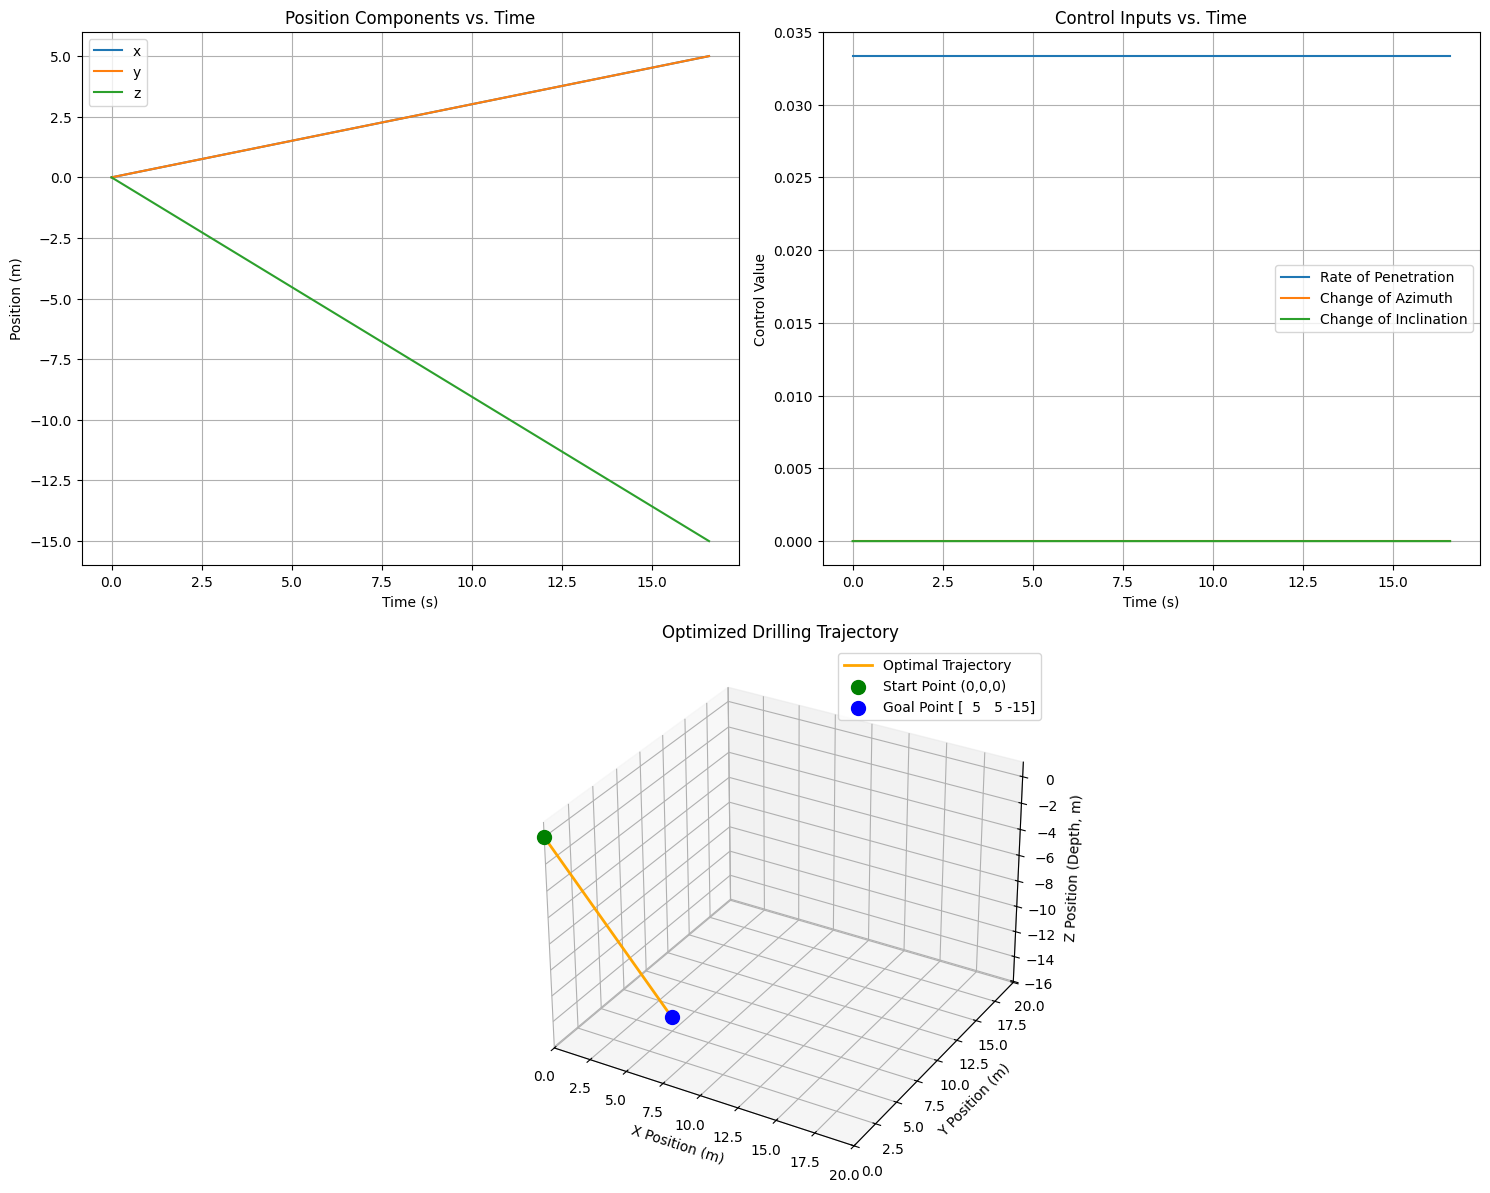

In [204]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3d = fig.add_subplot(2, 1, 2, projection='3d') # This subplot is for the 3D trajectory

# --- PLOT 1: Position vs. Time ---
ts, xs = sol(stage1).sample(x1, grid='integrator')
ax1.plot(ts, xs, label='x')
ts, ys = sol(stage1).sample(y1, grid='integrator')
ax1.plot(ts, ys, label='y')
ts, zs = sol(stage1).sample(z1, grid='integrator')
ax1.plot(ts, zs, label='z')
ts, xxs = sol(stage1).sample(inverse_rop1, grid='control')
ax1.set_title("Position Components vs. Time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Position (m)")
ax1.legend()
ax1.grid(True)


# --- PLOT 2: Control Inputs vs. Time ---
ts, vs = sol(stage1).sample(inverse_rop1, grid='control')
ax2.plot(ts, vs, label='Rate of Penetration')
ts, azimuth_s = sol(stage1).sample(u_az1_rate_ds, grid='control')
ax2.plot(ts, azimuth_s, label='Change of Azimuth')
ts, inclination_s = sol(stage1).sample(u_inc1_rate_ds, grid='control')
ax2.plot(ts, inclination_s, label='Change of Inclination')
ax2.set_title("Control Inputs vs. Time")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Control Value")
ax2.legend()
ax2.grid(True)


# --- PLOT 3: The 3D Trajectory ---
# The variables xs, ys, zs were already sampled for the first plot.
ax3d.plot(xs, ys, zs, label='Optimal Trajectory', linewidth=2, color='orange')
ax3d.scatter([0], [0], [0], c='green', s=100, label='Start Point (0,0,0)')
ax3d.scatter([target1[0]], [target1[1]], [target1[2]], c='blue', s=100, label=f'Goal Point {target1}')

# Set Labels, Title, and Legend
ax3d.set_xlabel("X Position (m)")
ax3d.set_ylabel("Y Position (m)")
ax3d.set_zlabel("Z Position (Depth, m)")
ax3d.set_title("Optimized Drilling Trajectory")
ax3d.legend()

# Set Axis Limits and Direction
ax3d.set_xlim(0, 20)
ax3d.set_ylim(0, 20)
# ax3d.invert_zaxis()
ax3d.invert_yaxis()
ax3d.invert_xaxis()

# Control the Viewing Angle
ax3d.view_init(elev=30, azim=120)


# --- Display EVERYTHING at Once ---
plt.tight_layout()
plt.show()